## Solving the Shallow Water Equations using the Discontinuous Galerkin Spectral Element Method
#### Following the semidiscretization proposed by Gassner, Winters, and Kopriva

We consider tha 1D shallow water equations (NSWEs) with bathymetry:
$$
\begin{align}
{\partial_t h} + {\partial_x (hu)} &= 0, \\
{\partial_t (hu)} + {\partial_x (hu^2 + \frac{1}{2}gh^2)} &= -gh{\partial_x b}.
\end{align}
$$
where $h$ is the height of the water, $u$ is the horizontal flow velocity, $g$ is the gravitational acceleration constant, and $b$ is the bathymetry. For simplicity we do not consider the treatment of dry states.

The skew-symmetric form of the NSWEs in a fixed element is:
$$
\begin{align}
&{h_t} + { (hu)_\xi} = 0, \\
&J [(hu)_t+hu_t]/2 + [(hu^2)u_\xi+(hu)u_\xi]/2+g(h+b)_\xi = 0.
\end{align}
$$
where $J=\frac{\Delta x}{2}$ is the Jacobian of the transformation from the reference element to the physical element.



In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Local libraries
from basis_nodes import generate_lagrange_poly, generate_LGL_points
from SBP_matrices import first_order_D, first_order_P_Q
from RHS_1D_advection import generate_RHS_1D_advection
from SSPRK import SSPRK33

### Defining a computational domain

In [2]:
## Computational domain

#Each element i will be enclosed by x_{i} and x_{i+1}
n_elements = 40
xlower = 0.
xupper = 2.
x = np.linspace(xlower,xupper, n_elements+1)

#Advection speed
c = 1.

#Spatial formal order of accuracy
order_x = 4

### Problem parameters

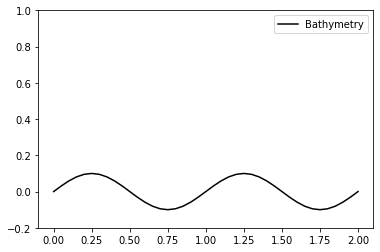

In [15]:
g = 1. #Gravitational acceleration constant
bathymetry_function = lambda x : 0.1*np.sin(2*np.pi*x) #Bathymetry function
#plot defining y limits
plt.plot(x, bathymetry_function(x), 'k', label='Bathymetry')
plt.ylim(-0.2,1.)
plt.legend()


### Nodes at reference element

In [12]:
#We'll need a Lagrange basis of degree order_x-1
#Thus, we will need order_x nodes in each element
degree_basis = order_x-1
if degree_basis >0:
    (_, _,
    _, _,
    _, _,
    xi_LGL_unsorted, w_LGL_unsorted) = generate_LGL_points(degree_basis)
else:
    xi_LGL_unsorted, w_LGL_unsorted = np.array([0.]), np.array([1.])

#######################
#######################
#The root finder returns unsorted roots,
#We fix that in these lines

#Indexes that would sort x_LG using value
sort_idxs_LGL = np.argsort(xi_LGL_unsorted)
#Sorting x_LG and w_LG using those indexes
xi_LGL = xi_LGL_unsorted[sort_idxs_LGL]
w_LGL = w_LGL_unsorted[sort_idxs_LGL]
#######################
#######################

n_nodes = len(xi_LGL)

### Mapping to physical element

In [16]:
#We map the nodes from the reference element to one of the elements 
#from our computational domain (this suffices since we are using an uniform grid)
x_min = x[0]
x_max = x[1]

#We just need to map the LGL nodes once since we are using a uniform grid
x_element = (xi_LGL*(x_max-x_min)+(x_min+x_max))/2
len_element = (x_max-x_min)/2. #Constant in this case
w_element = (x_max-x_min)*w_LGL
list_elements = [x_element]

#We define our grid (interface points will be repeated)
x_grid = np.zeros(n_elements*n_nodes)

#print(f"Numerical grid with double interface nodes")
for i in range(n_elements): 
    j = i*n_nodes
    x_grid[j:j+n_nodes] = x_element+x[i]
    list_elements.append(x_grid[j:j+n_nodes])
#    print(f"Element {i+1:}\t {x_grid[j:j+n_nodes]}")

### Define our SBP Operators

In [17]:
#Local opretaros P and Q
P_LGL, Q_LGL = first_order_P_Q(x_Lagrange_nodes=xi_LGL, x_abcissae=xi_LGL, w_abcissae=w_LGL)

#Global operators P and Q
P = np.kron(np.eye(n_elements), P_LGL)
Q = np.kron(np.eye(n_elements), Q_LGL)

diagP=np.diag(P)
diagPinv=1./diagP

#Restriction operators R, B
#Local
R_LGL = np.zeros((2,n_nodes))
R_LGL[0,0] = R_LGL[-1,-1] = 1
B_LGL = np.zeros((2,2))
B_LGL[0,0] = -1; B_LGL[-1,-1]=1
#Global
R = np.kron(np.eye(n_elements), R_LGL)
B = np.kron(np.eye(n_elements), B_LGL)


#Differential operator D
#Local
D_LGL = first_order_D(x_nodes=xi_LGL)
#Global
D = np.kron(np.eye(n_elements), D_LGL)


/Users/munozmca/Desktop/Courses/Spring_2023/SBP_Operators_AMCS348/basis_nodes.py:21: RuntimeWarning: invalid value encountered in divide
  return np.prod((x-x_nodes)/(xj-x_nodes), where = mask)
/Users/munozmca/Desktop/Courses/Spring_2023/SBP_Operators_AMCS348/basis_nodes.py:21: RuntimeWarning: divide by zero encountered in divide
  return np.prod((x-x_nodes)/(xj-x_nodes), where = mask)


### Flux function and numerical fluxes

In [18]:
#Flux functions (two components)
flux1_fun = lambda h, hu : hu
flux2_fun = lambda h, hu : hu**2/h + g*h**2/2

#Numerical fluxes (two components)
f_num1_fun = lambda hL, hR, uL, uR :np.double(0.25)*(uL +uR)*(hL + hR)
f_num2_fun = lambda hL, hR, uL, uR :np.double(0.125)*(uL+uR)**2*(hL+hR)+np.double(0.25)*g*(hL**2+hR**2)

#Global
def f_num_fun(h,hu,n_elements=n_elements,n_nodes=n_nodes):
    #Computing numerical flux just at the interface of elements
    #Fill numerical flux vector for first element
    #Will return two lists of fluxes, one for each component: f1 and f2
    u = hu/h
    
    if n_elements == 1:
        f1 = [flux1_fun(1.,0.), flux1_fun(h[0],hu[0])]    
        f2 = [flux2_fun(1.,0.), flux2_fun(h[0],hu[0])]
        return np.array(f)
    
    #For general periodic BCs
    f1 = [flux1_fun(1.,0.),                     #Left interface
        flux1_fun(h[n_nodes-1],hu[n_nodes-1])]  #Right interface
    f2 = [flux2_fun(1.,0.),                     #Left interface
        flux2_fun(h[n_nodes-1],hu[n_nodes-1])]  #Right interface

    for idx_elem in range(1,n_elements-1):
        #Left interface
        idx_R = idx_elem*n_nodes
        idx_L = idx_R-1
        f1.append(f_num1_fun(h[idx_L],h[idx_R],u[idx_L],u[idx_R]))
        f2.append(f_num2_fun(h[idx_L],h[idx_R],u[idx_L],u[idx_R]))
        #print(f"Element {idx_elem+1}")
        #print(f"Left interface")
        #print(f"{idx_L, idx_R}")

        #Right interface
        idx_R = (idx_elem+1)*n_nodes
        idx_L = idx_R-1
        f1.append(f_num1_fun(h[idx_L],h[idx_R],u[idx_L],u[idx_R]))
        f2.append(f_num2_fun(h[idx_L],h[idx_R],u[idx_L],u[idx_R]))
        #print(f"Right interface")
        #print(f"{idx_L, idx_R}")
        
    #Fill numerical flux vector for last element
    f1.append(flux1_fun(h[-n_nodes-1],hu[-n_nodes-1])) #Left interface
    f2.append(flux2_fun(h[-n_nodes-1],hu[-n_nodes-1])) #Left interface

    f1.append(flux1_fun(h[-1],hu[-1]))       #Right interface
    f2.append(flux2_fun(h[-1],hu[-1]))       #Right interface

        #print(f"Last element")
        #print(f"Left interface")
        #print(f"{-n_nodes-1, -n_nodes}")
        #print(f"Right interface")
        #print(f"{n_nodes*n_elements-1, 0}")
    return np.array(f1), np.array(f2)


## Semi-discrete RHS operator

In [ ]:
def RHS(q):
    #q will be a vector of size 2*n_nodes*n_elements
    #h contains the first half of elements and hu the second half
    h = q[:n_nodes*n_elements]
    hu = q[n_nodes*n_elements:]

    u = hu/h

    f1 = f_num1_fun(h,hu)
    f2 = f_num2_fun(h,hu)

    fnum1, fnum2 = f_num_fun(h,hu)

    RHS1 = -D@f1 - diagPinv*(R.T@B@(fnum1-R@f1))
    RHS2 = -D@f2 - 0.5*(D@(h*u**2)+hu*(D@u)+u*(D@f1)) - g*h*(D@h+bath) - diagPinv*(R.T@B@(fnum2-R@f2))
    
    return (1./len_element)*np.concatenate((RHS1,RHS2))
